#### <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:##909090">ETH Price Prediction Basic Model

#### <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:##909090">**by Anthony Amabile**

### Goal
Predict the price of ETH based on the price of BTC.


In [1]:
import pandas as pd
import plotly.express as px
from datetime import datetime

df = None

tickers = ['BTC', 'ETH']

for ticker in tickers:
    file = f'gemini_{ticker}USD_day.csv'
    print(f'Imported file {file}')
    df1= pd.read_csv(file)
    df1 = df1.loc[:,['Unix Timestamp','Close','Volume']]
    df1 = df1.rename(columns = {'Close': ticker,'Volume': ticker +'_Vol' })
    
    if df is None:
        df = df1
    else:
        df = pd.merge(df, df1, on='Unix Timestamp', how='outer')

df['Date'] = pd.to_datetime(df['Unix Timestamp'], unit='ms')
df = df.drop(df[df['Date'] < '2017-12-22'].index)

df.drop('Unix Timestamp', axis=1, inplace=True)


df.set_index('Date', inplace=True, drop=False)


for ticker in tickers:
    vol_col = ticker +'_Vol'
    fig_ticker = px.scatter(df, x='Date', y=ticker, size=vol_col, title=ticker)
    fig_ticker.show()

Imported file gemini_BTCUSD_day.csv
Imported file gemini_ETHUSD_day.csv


By now, we are all aware that BTC and ETH prices are highly correlated.
Looking at the hisotical prices graphs above, it is very apparent that they are correlated.

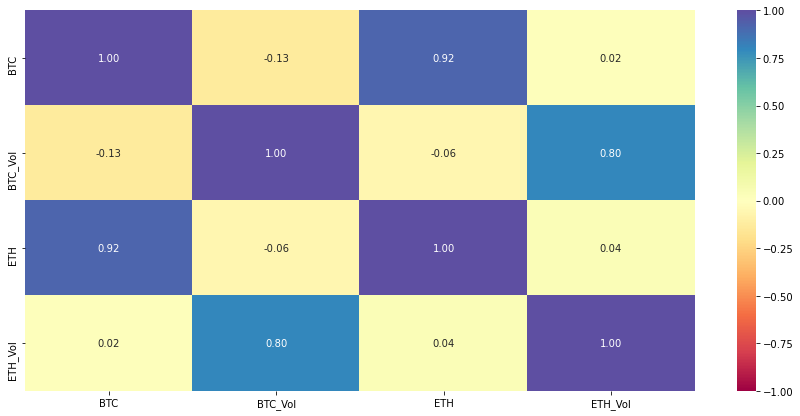

In [2]:
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
# to build linear regression_model
from sklearn.linear_model import LinearRegression
# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#df1 = df.copy()
correlation = df.corr()
plt.figure(figsize=(15,7))
sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')
plt.show()

You can see that the BTC and ETH are have a correlation of .92. Very strong correlation!

In [3]:

df2 = df.copy()
df2.drop(['Date', 'BTC_Vol','ETH_Vol'], axis=1, inplace=True)
df2 = df2.reset_index()
df2.drop('Date', axis=1, inplace=True)

X = df2.drop(["ETH"], axis=1)
y = df2["ETH"]
X = pd.get_dummies(
    X, 
    columns=X.select_dtypes(include=['object', 'category']).columns.tolist(), 
    drop_first=True,
)

x_train,x_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=1)




In [4]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(x_train, y_train)


LinearRegression()

In [5]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf


# Checking model performance on train set
print("Training Performance\n")
lin_reg_model_train_perf = model_performance_regression(lin_reg_model, x_train, y_train)
lin_reg_model_train_perf



Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,443.160765,305.282786,0.846035,0.845883,50.173247


In [6]:
# Checking model performance on test set
print("Test Performance\n")
lin_reg_model_test_perf = model_performance_regression(lin_reg_model, x_test, y_test)
lin_reg_model_test_perf

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,440.626654,295.028788,0.849246,0.848897,51.340895


**Observations**

- The train and test $R^2$ are 0.846 and 0.849, indicating that the model explains 84.6% and 84.9% of the total variation in both the train and test sets respectively. Also, both scores are comparable.

- RMSE values on the train and test sets are also comparable.

- This shows that the model is not overfitting.

- MAE indicates that our current model is able to predict ETH prices within a mean error of $295 on the test set.

- MAPE of 50 on the test data means that we are able to predict within ~50% the price of ETH.

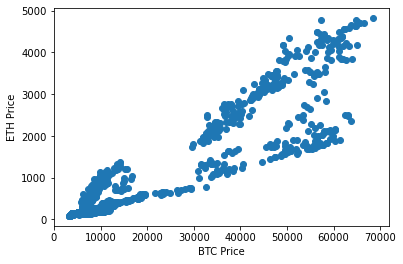

In [7]:
#X.drop(['BTC_Vol', 'ETH_Vol'], axis=1, inplace=True)
plt.xlabel("BTC Price")
plt.ylabel("ETH Price")
plt.plot(X, y, 'o')

plt.show()
